# U.S. mail voting statistics

#### Source: U.S. Election Assistance Commission [survey](https://www.eac.gov/research-and-data/datasets-codebooks-and-surveys)

In [1]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
pd.options.display.max_columns = 50
pd.options.display.max_rows = 34000
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.1f}'.format

### Read data from the 2018 general election

In [2]:
src = pd.read_csv('input/EAVS_2018_for_Public_Release_Updates3.csv', encoding='Latin-1', low_memory=False, na_values=['(NA)']).fillna(0)

In [3]:
# src = pd.read_excel('input/EAVS 2016 Final Data for Public Release v.4.xls')

### Reduce the number of columns to those we're interested in, and give them useful names

In [4]:
mail_ballots = src[[ 'FIPSCode', 'Jurisdiction_Name', 'State_Abbr', 'A1b', 'C1a', 'C1b', 'C3a', 'C4e', 'C4a', 'D1a']].fillna('')

In [5]:
mail_ballots = mail_ballots.rename(columns={ 'FIPSCode':'fips', 'State_Abbr':'state', \
                                            'Jurisdiction_Name':'place','A1b':'active_voters', 'C1a':'mail_ballots_sent', \
                             'C1b':'mail_ballots_returned', 'C3a':'mail_ballots_counted', 'C4a':'mail_ballots_rejected', \
                             'D1a': 'total_votes_cast', 'C4e':'non_match_sig'  })

### Clean up numeric columns that contain strings for missing data

In [6]:
strings = ['Data not available', 'Does not apply']
columns = ['active_voters', 'mail_ballots_sent', 'mail_ballots_returned',\
           'mail_ballots_counted', 'mail_ballots_rejected', 'total_votes_cast', 'non_match_sig']

In [7]:
mail_ballots[columns] = mail_ballots[columns].apply(pd.to_numeric, errors='coerce', axis=1)

In [8]:
mail_ballots['fips'] = mail_ballots['fips'].astype(str).str.replace('00000','').str.zfill(5)

### Isolate swing states

In [9]:
# Those in the middle of the snake: https://projects.fivethirtyeight.com/2020-election-forecast/
swing = ['MI','OH','PA','NC','WI','AZ','FL','NV', 'MN']

In [10]:
mail_ballots['mail_ballots_rejected'] = mail_ballots['mail_ballots_rejected'].replace(-88, 0)
mail_ballots['non_match_sig'] = mail_ballots['non_match_sig'].replace(-88, 0)

---

### National totals

#### Total mail ballots rejected

In [11]:
mail_ballots['mail_ballots_rejected'].sum()

430196.0

In [12]:
mail_ballots['mail_ballots_returned'].sum()

30401420.0

In [13]:
mail_ballots['non_match_sig'].sum()

63569.0

#### % of mail ballots rejected

In [14]:
(((mail_ballots['mail_ballots_rejected'].sum() / mail_ballots['mail_ballots_returned'].sum())*100)).round(2)

1.42

#### % of those rejected because of non-matching signature

In [15]:
(((mail_ballots['non_match_sig'].sum() / mail_ballots['mail_ballots_rejected'].sum())*100)).round(2)

14.78

#### % of all votes cast that were mail ballots

In [16]:
(((mail_ballots['mail_ballots_counted'].sum() / mail_ballots['total_votes_cast'].sum())*100)).round(2)

23.64

---

### Aggregate by state

In [17]:
states = mail_ballots.groupby(['state']).agg('sum').reset_index()

### Calculate our rates for states

In [18]:
states['mail_rejected_rate'] = ((states['mail_ballots_rejected'] / states['mail_ballots_returned'])*100)

In [19]:
states['mail_pct_all_votes'] = ((states['mail_ballots_counted'] / states['total_votes_cast'])*100)

### Signature mismatch as a reason for the rejection

In [20]:
states['mail_rejected_sig_pct'] = ((states['non_match_sig'] / states['mail_ballots_rejected'])*100)

In [21]:
states['mail_rejected_sig_pct_all'] = ((states['non_match_sig'] / states['mail_ballots_returned'])*100)

In [22]:
states.head()

state  active_voters  mail_ballots_sent  mail_ballots_returned  \
0    AK      571,851.0           29,257.0               24,425.0   
1    AL    3,164,301.0           63,291.0               57,832.0   
2    AR    1,456,887.0           17,120.0               15,208.0   
3    AS        8,462.0               51.0                   36.0   
4    AZ    3,715,624.0        2,672,384.0            1,899,240.0   

   mail_ballots_counted  non_match_sig  mail_ballots_rejected  \
0              23,667.0            0.0                  758.0   
1              54,833.0            0.0                1,368.0   
2              11,611.0           21.0                1,150.0   
3                   0.0            0.0                    0.0   
4           1,874,489.0        1,516.0                8,567.0   

   total_votes_cast  mail_rejected_rate  mail_pct_all_votes  \
0         285,009.0                 3.1                 8.3   
1       1,726,638.0                 2.4                 3.2   
2         814,887.0                 7.6                 1.4   
3           8,462.0                 0.0                 0.0   
4       2,409,906.0                 0.5                77.8   

   mail_rejected_sig_pct  mail_rejected_sig_pct_all  
0                    0.0                        0.0  
1                    0.0                        0.0  
2                    1.8                        0.1  
3                    nan                        0.0  
4                   17.7                        0.1

### Merge AP states

In [23]:
ap = pd.read_csv('input/ap_states.csv')

In [24]:
ap.head()

name usps      ap
0     Alabama   AL    Ala.
1      Alaska   AK  Alaska
2     Arizona   AZ   Ariz.
3    Arkansas   AR    Ark.
4  California   CA  Calif.

In [25]:
states_ap = pd.merge(ap, states, left_on='usps', right_on='state')

In [26]:
states_ap = states_ap.drop(['usps'], axis=1)

In [27]:
states_ap[['state', 'ap', 'name', 'mail_ballots_returned', 'mail_ballots_counted', 'mail_ballots_rejected', \
        'mail_rejected_sig_pct', 'mail_rejected_sig_pct_all']]\
.sort_values('mail_rejected_sig_pct', ascending=False).to_csv('output/mail_rejected_sig_pct.csv', index=False)

In [28]:
states_ap[['state', 'ap', 'name', 'mail_ballots_returned', 'mail_ballots_counted', 'mail_ballots_rejected', \
        'mail_rejected_sig_pct', 'mail_rejected_sig_pct_all']]\
.sort_values('mail_rejected_sig_pct', ascending=False).head(20)

state      ap                  name  mail_ballots_returned  \
5     CO   Colo.              Colorado            2,449,409.0   
34    ND    N.D.          North Dakota               96,125.0   
47    WA   Wash.            Washington            3,112,157.0   
39    RI    R.I.          Rhode Island               27,193.0   
44    UT    Utah                  Utah              973,915.0   
37    OR    Ore.                Oregon            1,907,342.0   
11    HI  Hawaii                Hawaii              224,404.0   
26    MT   Mont.               Montana              367,561.0   
43    TX   Texas                 Texas              533,566.0   
2     AZ   Ariz.               Arizona            1,899,240.0   
9     FL    Fla.               Florida            2,604,544.0   
30    NJ    N.J.            New Jersey              406,325.0   
8     DC    D.C.  District of Columbia                9,351.0   
4     CA  Calif.            California            8,286,228.0   
12    ID   Idaho                 Idaho               76,197.0   
23    MN   Minn.             Minnesota              640,707.0   
28    NV    Nev.                Nevada               86,633.0   
14    IN    Ind.               Indiana              762,511.0   
22    MI   Mich.              Michigan            1,061,835.0   
16    KS    Kan.                Kansas              172,743.0   

    mail_ballots_counted  mail_ballots_rejected  mail_rejected_sig_pct  \
5            2,430,239.0               19,170.0                   68.0   
34              95,562.0                  554.0                   60.3   
47           3,064,219.0               32,327.0                   53.3   
39              26,418.0                  775.0                   43.1   
44             965,147.0                8,768.0                   36.7   
37               7,043.0                  176.0                   35.2   
11             195,149.0                1,638.0                   35.2   
26             366,188.0                1,373.0                   28.4   
43             527,787.0                9,377.0                   20.0   
2            1,874,489.0                8,567.0                   17.7   
9            2,585,374.0               30,540.0                   16.6   
30             392,931.0               11,694.0                   16.4   
8                9,019.0                  332.0                   13.3   
4            8,289,322.0              161,660.0                   10.0   
12              72,872.0                1,188.0                    6.6   
23             632,868.0                7,479.0                    6.1   
28              84,396.0                1,772.0                    6.0   
14             750,339.0                3,419.0                    5.7   
22           1,055,822.0                6,013.0                    5.0   
16             170,641.0                1,879.0                    4.8   

    mail_rejected_sig_pct_all  
5                         0.5  
34                        0.3  
47                        0.6  
39                        1.2  
44                        0.3  
37                        0.0  
11                        0.3  
26                        0.1  
43                        0.4  
2                         0.1  
9                         0.2  
30                        0.5  
8                         0.5  
4                         0.2  
12                        0.1  
23                        0.1  
28                        0.1  
14                        0.0  
22                        0.0  
16                        0.1

### States with highest mail ballot rejection rates?

In [29]:
states_ap.sort_values('mail_rejected_rate', ascending=False).head(60)

name      ap state  active_voters  mail_ballots_sent  \
32              New York    N.Y.    NY   11,676,266.0          341,270.0   
3               Arkansas    Ark.    AR    1,456,887.0           17,120.0   
17              Kentucky     Ky.    KY    3,402,905.0           29,244.0   
33        North Carolina    N.C.    NC    5,898,244.0          126,142.0   
18             Louisiana     La.    LA    2,856,722.0           65,442.0   
21         Massachusetts   Mass.    MA    3,947,897.0          105,454.0   
7               Delaware    Del.    DE      672,632.0           17,392.0   
36              Oklahoma   Okla.    OK    1,857,700.0           94,598.0   
38          Pennsylvania     Pa.    PA    7,738,989.0          216,575.0   
8   District of Columbia    D.C.    DC      511,633.0           12,400.0   
1                 Alaska  Alaska    AK      571,851.0           29,257.0   
10               Georgia     Ga.    GA    6,437,524.0          281,490.0   
40        South Carolina    S.C.    SC    3,538,580.0           80,271.0   
30            New Jersey    N.J.    NJ    5,456,506.0          563,106.0   
39          Rhode Island    R.I.    RI      737,419.0           31,677.0   
45               Vermont     Vt.    VT      447,709.0           28,317.0   
29         New Hampshire    N.H.    NH      988,148.0           46,831.0   
0                Alabama    Ala.    AL    3,164,301.0           63,291.0   
25              Missouri     Mo.    MO    3,803,881.0          227,927.0   
42             Tennessee   Tenn.    TN    3,764,513.0           43,561.0   
46              Virginia     Va.    VA    5,272,602.0          102,570.0   
13              Illinois    Ill.    IL    8,091,045.0          523,372.0   
28                Nevada    Nev.    NV    1,563,750.0          103,810.0   
4             California  Calif.    CA   19,724,297.0       13,687,191.0   
6            Connecticut   Conn.    CT    2,193,586.0           96,559.0   
43                 Texas   Texas    TX   13,790,247.0          621,386.0   
20              Maryland     Md.    MD    3,954,027.0          146,208.0   
49             Wisconsin    Wis.    WI    3,442,004.0          168,788.0   
15                  Iowa    Iowa    IA    2,037,516.0          358,659.0   
12                 Idaho   Idaho    ID      917,609.0           81,172.0   
35                  Ohio    Ohio    OH    8,070,917.0        1,030,261.0   
9                Florida    Fla.    FL   13,278,070.0        3,499,503.0   
23             Minnesota   Minn.    MN    3,422,515.0          722,326.0   
19                 Maine   Maine    ME    1,054,068.0          193,470.0   
16                Kansas    Kan.    KS    1,670,217.0          191,602.0   
47            Washington   Wash.    WA    4,362,480.0        4,460,649.0   
48         West Virginia   W.Va.    WV      961,894.0           12,063.0   
44                  Utah    Utah    UT    1,433,917.0        1,469,654.0   
27              Nebraska    Neb.    NE    1,096,862.0          186,204.0   
5               Colorado   Colo.    CO    3,426,499.0        3,467,664.0   
24           Mississippi   Miss.    MS    1,880,197.0           69,904.0   
11                Hawaii  Hawaii    HI      712,765.0          286,229.0   
34          North Dakota    N.D.    ND            0.0          101,568.0   
22              Michigan   Mich.    MI    6,488,823.0        1,123,415.0   
2                Arizona   Ariz.    AZ    3,715,624.0        2,672,384.0   
14               Indiana    Ind.    IN    4,168,374.0          766,722.0   
50               Wyoming    Wyo.    WY      283,941.0           63,728.0   
26               Montana   Mont.    MT      616,642.0          442,425.0   
41          South Dakota    S.D.    SD      539,788.0           89,616.0   
31            New Mexico    N.M.    NM      698,172.0          448,987.0   
37                Oregon    Ore.    OR    2,748,232.0        2,860,072.0   

    mail_ballots_returned  mail_ballots_counted  non_match_sig  \
3

### States with highest vote by mail rates?

In [30]:
states_ap.sort_values('mail_rejected_rate', ascending=False).to_csv('output/states_mail_rejected_rate.csv', index=False)

### Calculate our rates for counties

In [31]:
mail_ballots['mail_ballots_rejected'] = mail_ballots['mail_ballots_rejected'].replace(-88, 0)

In [32]:
mail_ballots['mail_rejected_rate'] = ((mail_ballots['mail_ballots_rejected'] / mail_ballots['mail_ballots_returned'])*100)

In [33]:
mail_ballots['mail_rejected_sig_pct_all'] = ((mail_ballots['non_match_sig'] / mail_ballots['mail_ballots_returned'])*100)

In [34]:
mail_ballots['mail_rejected_sig_pct'] = ((mail_ballots['non_match_sig'] / mail_ballots['mail_ballots_rejected'])*100)

In [35]:
mail_ballots['mail_pct_all_votes'] = ((mail_ballots['mail_ballots_counted'] / mail_ballots['total_votes_cast'])*100)

### Populous places in 'swing' states with the highest rates?

In [36]:
mail_ballots[(mail_ballots['state'].isin(swing)) &\
            (mail_ballots['active_voters'] > 100000)].sort_values('mail_rejected_rate', ascending=False).head(20)

fips               place state  active_voters  mail_ballots_sent  \
3236  37147         PITT COUNTY    NC      101,939.0            1,168.0   
3188  37051   CUMBERLAND COUNTY    NC      162,989.0            3,250.0   
3227  37129  NEW HANOVER COUNTY    NC      140,086.0            2,466.0   
3556  42079      LUZERNE COUNTY    PA      180,874.0            5,083.0   
3564  42095  NORTHAMPTON COUNTY    PA      187,638.0            5,049.0   
3194  37063       DURHAM COUNTY    NC      190,486.0            3,274.0   
3583  42133         YORK COUNTY    PA      262,448.0            6,334.0   
3173  37021     BUNCOMBE COUNTY    NC      169,368.0            3,702.0   
3203  37081     GUILFORD COUNTY    NC      306,103.0            7,229.0   
3539  42045     DELAWARE COUNTY    PA      363,320.0           10,445.0   
3562  42091   MONTGOMERY COUNTY    PA      523,501.0           19,598.0   
3196  37067      FORSYTH COUNTY    NC      218,634.0            5,868.0   
3531  42029      CHESTER COUNTY    PA      324,843.0           14,649.0   
3363  39095               LUCAS    OH      307,175.0           30,367.0   
3526  42019       BUTLER COUNTY    PA      118,210.0            3,694.0   
3552  42071    LANCASTER COUNTY    PA      299,661.0            7,979.0   
3522  42011        BERKS COUNTY    PA      230,861.0            5,038.0   
3555  42077       LEHIGH COUNTY    PA      209,029.0            5,598.0   
3175  37025     CABARRUS COUNTY    NC      116,457.0            3,297.0   
3252  37179        UNION COUNTY    NC      133,009.0            3,537.0   

      mail_ballots_returned  mail_ballots_counted  non_match_sig  \
3236                  857.0                 702.0            1.0   
3188                2,190.0               1,907.0            1.0   
3227                1,938.0               1,726.0            0.0   
3556                4,620.0               4,169.0            nan   
3564                4,583.0               4,135.0            nan   
3194                2,420.0               2,204.0            1.0   
3583                5,713.0               5,201.0            nan   
3173                2,912.0               2,662.0            5.0   
3203                5,611.0               5,131.0            1.0   
3539                9,374.0               8,521.0            nan   
3562               17,235.0              15,771.0            nan   
3196                4,734.0               4,363.0            1.0   
3531               13,063.0              11,989.0            nan   
3363               26,758.0              24,727.0           11.0   
3526                3,431.0               3,182.0            nan   
3552                7,392.0               6,830.0            nan   
3522                4,598.0               4,264.0            nan   
3555                5,144.0               4,780.0            nan   
3175                2,487.0               2,340.0            0.0   
3252                2,498.0               2,351.0            0.0   

      mail_ballots_rejected  total_votes_cast  mail_rejected_rate  \
3236                  155.0          59,917.0                18.1   
3188                  283.0          94,223.0                12.9   
3227                  212.0          89,380.0                10.9   
3556                  448.0         108,773.0                 9.7   
3564                  419.0         116,884.0                 9.1   
3194                  216.0         129,034.0                 8.9   
3583                  498.0         169,810.0                 8.7   
3173                  250.0         119,837.0                 8.6   
3203                  480.0         202,467.0                 8.6   
3539                  783.0         252,778.0                 8.4   
3562                1,382.0         384,750.0                 8.0   
3196                  371.0         137,750.0                 7.8   
3531                  994.0         236,961.0                 7.6   
3363                2,031.0         

In [37]:
mail_ballots[(mail_ballots['active_voters'] > 100000) & (mail_ballots['mail_ballots_rejected'] > 100)]\
    [['place', 'state', 'mail_ballots_returned', 'mail_ballots_rejected', 'non_match_sig','mail_rejected_sig_pct', 'mail_rejected_sig_pct_all', 'mail_rejected_rate']]\
    .sort_values('mail_rejected_rate', ascending=False).head(20)

place state  mail_ballots_returned  mail_ballots_rejected  \
3124        KINGS COUNTY    NY               20,840.0                7,498.0   
3141       QUEENS COUNTY    NY               17,271.0                6,212.0   
3131     NEW YORK COUNTY    NY               25,950.0                7,010.0   
3136       ORANGE COUNTY    NY                6,370.0                1,174.0   
3236         PITT COUNTY    NC                  857.0                  155.0   
3160  WESTCHESTER COUNTY    NY               10,409.0                1,736.0   
3103        BRONX COUNTY    NY                7,303.0                1,140.0   
1192       KENTON COUNTY    KY                  846.0                  120.0   
3114     DUTCHESS COUNTY    NY                6,168.0                  825.0   
1167      FAYETTE COUNTY    KY                2,502.0                  334.0   
4041        SMITH COUNTY    TX                5,759.0                  754.0   
143       PULASKI COUNTY    AR                2,644.0                  344.0   
3188   CUMBERLAND COUNTY    NC                2,190.0                  283.0   
3143     RICHMOND COUNTY    NY                5,957.0                  764.0   
3227  NEW HANOVER COUNTY    NC                1,938.0                  212.0   
3556      LUZERNE COUNTY    PA                4,620.0                  448.0   
1281    LAFAYETTE PARISH    LA                1,741.0                  162.0   
36      JEFFERSON COUNTY    AL                7,218.0                  665.0   
3564  NORTHAMPTON COUNTY    PA                4,583.0                  419.0   
3194       DURHAM COUNTY    NC                2,420.0                  216.0   

      non_match_sig  mail_rejected_sig_pct  mail_rejected_sig_pct_all  \
3124            0.0                    0.0                        0.0   
3141            0.0                    0.0                        0.0   
3131            0.0                    0.0                        0.0   
3136           18.0                    1.5                        0.3   
3236            1.0                    0.6                        0.1   
3160            0.0                    0.0                        0.0   
3103            0.0                    0.0                        0.0   
1192            0.0                    0.0                        0.0   
3114            0.0                    0.0                        0.0   
1167            7.0                    2.1                        0.3   
4041            nan                    nan                        nan   
143             nan                    nan                        nan   
3188            1.0                    0.4                        0.0   
3143            0.0                    0.0                        0.0   
3227            0.0                    0.0                        0.0   
3556            nan                    nan                        nan   
1281            0.0                    0.0                        0.0   
36              0.0                    0.0                        0.0   
3564            nan                    nan                        nan   
3194            1.0                    0.5                        0.0   

      mail_rejected_rate  
3124                36.0  
3141                36.0  
3131                27.0  
3136                18.4  
3236                18.1  
3160                16.7  
3103                15.6  
1192                14.2  
3114                13.4  
1167                13.3  
4041                13.1  
143                 13.0  
3188                12.9  
3143                12.8  
3227                10.9  
3556                 9.7  
1281                 9.3  
36                   9.2  
3564                 9.1  
3194                 8.9

### Just counties with more than 50,000 voters

In [38]:
mail_ballots_large = mail_ballots[mail_ballots['active_voters'] > 50000]

### Isolate just California 

In [39]:
mail_ballots_ca = mail_ballots[mail_ballots['state'] == 'CA']

### What's up in Los Angeles County? 

In [40]:
mail_ballots[(mail_ballots['state'] == 'CA') &\
(mail_ballots['place'] == 'LOS ANGELES COUNTY')].iloc[0]

fips                                      06037
place                        LOS ANGELES COUNTY
state                                        CA
active_voters                       5,280,658.0
mail_ballots_sent                   2,723,457.0
mail_ballots_returned               1,346,022.0
mail_ballots_counted                1,330,611.0
non_match_sig                               0.0
mail_ballots_rejected                  15,412.0
total_votes_cast                    3,023,417.0
mail_rejected_rate                          1.1
mail_rejected_sig_pct_all                   0.0
mail_rejected_sig_pct                       0.0
mail_pct_all_votes                         44.0
Name: 177, dtype: object

### Which California counties have the highest rejection rates?

In [41]:
mail_ballots_ca.sort_values('mail_rejected_rate', ascending=False).head(10)

fips          place state  active_voters  mail_ballots_sent  \
169  06021   GLENN COUNTY    CA       12,816.0           19,517.0   
176  06035  LASSEN COUNTY    CA       14,332.0           11,972.0   
182  06047  MERCED COUNTY    CA       97,584.0           73,874.0   
173  06029    KERN COUNTY    CA      375,759.0          252,121.0   
183  06049   MODOC COUNTY    CA        5,118.0            3,869.0   
174  06031   KINGS COUNTY    CA       52,631.0           43,039.0   
216  06115    YUBA COUNTY    CA       33,754.0           23,084.0   
212  06107  TULARE COUNTY    CA      169,367.0          122,369.0   
168  06019  FRESNO COUNTY    CA      456,891.0          289,112.0   
178  06039  MADERA COUNTY    CA       57,418.0           58,537.0   

     mail_ballots_returned  mail_ballots_counted  non_match_sig  \
169                7,578.0               6,838.0           50.0   
176                8,065.0               7,082.0            3.0   
182               43,601.0              40,108.0          658.0   
173              136,408.0             134,054.0        1,214.0   
183                2,833.0               2,623.0            6.0   
174               25,188.0              23,375.0          112.0   
216               14,704.0              13,682.0          169.0   
212               75,394.0              70,652.0          337.0   
168              163,391.0             161,151.0          370.0   
178               36,457.0              34,489.0          255.0   

     mail_ballots_rejected  total_votes_cast  mail_rejected_rate  \
169                1,181.0           8,441.0                15.6   
176                  983.0           9,154.0                12.2   
182                3,493.0          57,491.0                 8.0   
173               10,471.0         205,816.0                 7.7   
183                  210.0           3,497.0                 7.4   
174                1,813.0          30,606.0                 7.2   
216                1,022.0          19,643.0                 7.0   
212                4,742.0         101,066.0                 6.3   
168                9,148.0         256,972.0                 5.6   
178                1,968.0          38,890.0                 5.4   

     mail_rejected_sig_pct_all  mail_rejected_sig_pct  mail_pct_all_votes  
169                        0.7                    4.2                81.0  
176                        0.0                    0.3                77.4  
182                        1.5                   18.8                69.8  
173                        0.9                   11.6                65.1  
183                        0.2                    2.9                75.0  
174                        0.4                    6.2                76.4  
216                        1.1                   16.5                69.7  
212                        0.4                    7.1                69.9  
168                        0.2                    4.0                62.7  
178                        0.7                   13.0                88.7

### Which large U.S. counties have the highest rejection rates?

In [42]:
mail_ballots_large.sort_values('mail_rejected_rate', ascending=False).head(10)

fips               place state  active_voters  mail_ballots_sent  \
3124  36047        KINGS COUNTY    NY    1,460,396.0           29,638.0   
3141  36081       QUEENS COUNTY    NY    1,180,052.0           22,226.0   
3131  36061     NEW YORK COUNTY    NY    1,016,771.0           33,498.0   
680   66000                GUAM    GU       55,941.0              624.0   
3136  36071       ORANGE COUNTY    NY      220,262.0            8,370.0   
3236  37147         PITT COUNTY    NC      101,939.0            1,168.0   
3160  36119  WESTCHESTER COUNTY    NY      593,559.0           23,831.0   
3103  36005        BRONX COUNTY    NY      721,734.0           10,145.0   
777   17093      KENDALL COUNTY    IL       78,227.0            2,819.0   
3191  37057     DAVIDSON COUNTY    NC       91,376.0            2,022.0   

      mail_ballots_returned  mail_ballots_counted  non_match_sig  \
3124               20,840.0              16,269.0            0.0   
3141               17,271.0              13,375.0            0.0   
3131               25,950.0              21,885.0            0.0   
680                   367.0                 298.0            nan   
3136                6,370.0               5,702.0           18.0   
3236                  857.0                 702.0            1.0   
3160               10,409.0              18,303.0            0.0   
3103                7,303.0               6,526.0            0.0   
777                 2,445.0               2,445.0            nan   
3191                1,641.0               1,406.0            2.0   

      mail_ballots_rejected  total_votes_cast  mail_rejected_rate  \
3124                7,498.0         645,096.0                36.0   
3141                6,212.0         504,309.0                36.0   
3131                7,010.0         540,445.0                27.0   
680                    69.0          37,386.0                18.8   
3136                1,174.0         125,924.0                18.4   
3236                  155.0          59,917.0                18.1   
3160                1,736.0         339,931.0                16.7   
3103                1,140.0         292,565.0                15.6   
777                   367.0          46,201.0                15.0   
3191                  235.0          57,427.0                14.3   

      mail_rejected_sig_pct_all  mail_rejected_sig_pct  mail_pct_all_votes  
3124                        0.0                    0.0                 2.5  
3141                        0.0                    0.0                 2.7  
3131                        0.0                    0.0                 4.0  
680                         nan                    nan                 0.8  
3136                        0.3                    1.5                 4.5  
3236                        0.1                    0.6                 1.2  
3160                        0.0                    0.0                 5.4  
3103                        0.0                    0.0                 2.2  
777                         nan                    nan                 5.3  
3191                        0.1                    0.9                 2.4

---

## Geography

### All U.S. counties

In [43]:
counties_geo = gpd.read_file('input/county_w_lakes_small.json')

### CA counties

In [44]:
counties_ca_geo = counties_geo[counties_geo['statefp']=='06']

<AxesSubplot:>

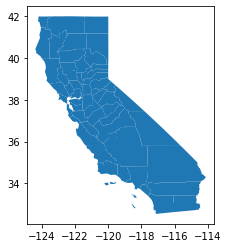

In [45]:
counties_ca_geo.plot()

### States

In [46]:
states_geo = gpd.read_file('input/states.json')

<AxesSubplot:>

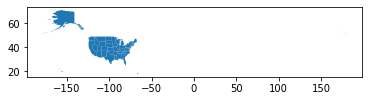

In [47]:
states_geo.plot()

### Townships

In [48]:
townships_geo = gpd.read_file('input/tl_2018_23_cousub/tl_2018_23_cousub.shp')

<AxesSubplot:>

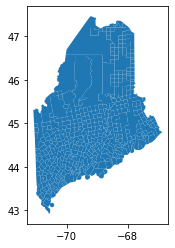

In [49]:
townships_geo.plot()

In [50]:
mail_ballots_geo_counties = counties_geo.merge(mail_ballots, left_on='geoid', right_on='fips')

In [51]:
mail_ballots_geo_ca_counties = counties_ca_geo.merge(mail_ballots_ca, left_on='geoid', right_on='fips')

In [52]:
mail_ballots_geo_states = states_geo.merge(states, left_on='STUSPS', right_on='state')

### Export geo files

In [53]:
mail_ballots_geo_counties.to_file('output/mail_ballots_geo_counties.geojson', driver='GeoJSON')

In [54]:
mail_ballots_geo_states.to_file('output/mail_ballots_geo_states.geojson', driver='GeoJSON')

In [55]:
mail_ballots_geo_ca_counties.to_file('output/mail_ballots_geo_ca_counties.geojson', driver='GeoJSON')

### Export text files

In [56]:
states.to_csv('output/states.csv', index=False)

In [57]:
mail_ballots_ca.to_csv('output/mail_ballots_ca.csv', index=False)